This will demonstrate some of the main classes in `bounder.region`.

Bounder is a package for spatial boundary analysis. This means that it both is concerned with the statistical process of *detecting* boundaries, sometimes called "wombling" in geographic (mainly spatial epidemiological) literature, and partitioning a graph into many, mutually exhaustive, potentially-contiguous subgraphs. 

The wombling component is on hold pending institutional support to continue. It lives in `bounder/womble`.

The regionalization component is under active development. It lives under `bounder/region`. Three "families" of classes are helpful to discuss to get your head around the design philosophy of this part of the package. 

First, I'll show how to get the thing imported. 

Unfortunately, I'm building bounder on top of libpysal. Libpysal is available from pypi right now, but you need the development version of the package. To get this, I would:

1. clone `github.com/pysal/libpysal`
2. run `2to3 -nw --output=libpysal3 libpysal/libpysal`. This command will provide a python3 version of the source code of libpysal. `bounder` uses the weights code & adjacency list representation extensively. 
3. run the stuff below, replacing `../libpysal3` with the path to your libpysal3 copy. 

In [1]:
import sys
sys.path.insert(0,'../libpysal3/')
from bounder import region
import pysal as ps
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

At a very high level, I view regionalization problems as composed of four distinct steps:

1. specification of objective & constraint functions
2. construction of an initial solution
3. refinement of the initial solution (optional)
4. assessment of validity of the refined solution

So I've built a framework that supports this. Namely, I aim to provide distinct `Objective` and `Constraint` classes that provide an abstraction capable of flexibly defining a regionalization problem using many different objectives or constraints. 

Then, I aim to provide methods to initialize solutions using many different backends, such as `scikit`, or accept a pre-configured initialization. 

After this, I aim to implement many different metaheuristics for refinement of the initial solution. 

Finally, to assess the refinement quality (or initial solution quality), I provide a robust framework to work with the `Constraint` and `Objective` classes that can characterize both the slack of the solution (in a [linear programming sense](https://en.wikipedia.org/wiki/Slack_variable)) and the fitness according to the objective. 

In [2]:
data = gpd.read_file(ps.examples.get_path('south.shp'))
data = data.query('STATE_NAME == "Texas"')

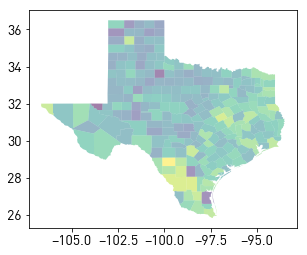

In [3]:
data.plot('FH90', linewidth=0)
plt.show()

# Objectives & Constraints

One set of spatial regionalization problems focused on by `clusterpy` involves the minimization of within-group variance while ensuring that groups have a sufficiently-large population and groups are connnected graphs. In theory, this represents a specific objective and set of constraints.

To see how this works in `bounder`, you need to envision what the structure of the problem is. The problem `Objective` is a statement about *what* variable is being assesed (the `key`) and *how* the regions should be assessed (the `fn`, or function). Initializing the Objective is as simple as that:

In [4]:
obj = region.Objective(key = 'FH90', fn=np.var)
obj = region.Objective.from_kw(FH90 = np.var) #also works

The objective object is actually *callable*, and it applies the `fn` to a pandas `GroupBy` object. Typically, as regions are improved, the `GroupBy` is conducted over the set of `current_labels`. As an example, I'll assign some random labels and show how the `GroupBy` is passed to the objective. 

In [5]:
data['current_labels'] = np.random.randint(0,5, size=len(data))

In [6]:
grouper = data.groupby('current_labels')

In [7]:
obj(grouper)

76.16297382454151

Thus, the objective computes the function supplied to its inititialization to all regions and then uses `obj.reduction` to reduce the vector of region scores to a single map score. By default, `reduction` is a sum. But, it could be any python callable that returns a scalar. 

In [8]:
obj.reduction

<function numpy.core.fromnumeric.sum>

For example, if we wanted to minimize the maximum regional variance instead of the sums of regional variances:

In [14]:
obj_minimax = region.Objective(key = 'FH90', fn=np.var,
                                  reduction=np.max)

In [15]:
obj_minimax(grouper)

18.231437227945452

In [18]:
obj_minimax.reduction

<function numpy.core.fromnumeric.amax>

Constraints are similar, but require a slightly different syntax so that the callable can be separated from the limiting value. Typically, a constraint takes the form:

$$f(X) \leq c$$

where $X$ is some property of the data and $c$ is the limiting value. One useful property is the extent to which a constraint is either satisfied or not satisfied. Typically, in classical linear programming, this involves the introduction of a "slack" term, that converts the inequality to strict equality:

$$f(X) + s = c$$

Then, $s$ simply assumes the difference between $f(X)$ and $c$ over the course of the solution. Feasibility can be assessed from the problems' slack vector alone. 

Unfortunately, we cannot just translate those statements directly into python, since the inequality can't be "split" and the slack term introduced *after the function is created*:

In [19]:
fn = lambda X: np.sum(X) < 5

In [22]:
print(fn(10), fn(12))

False False


We can't know how *badly* the constraint isn't satisfied without separating this function before declaration. The syntax I've decided on is:

In [61]:
const = region.Constraint(HR90 = np.mean).below(8.25)
const

This way, the constraint expresses what is being constrained (`HR90` in this case), the function being applied (`np.mean` in this case), whether the constraint is a floor or a ceiling (`below`, `above` in general), and the limiting value (`10` in this case). 

Moving forward, then, the constraint can be assesed in a few ways. To simply apply the constraint function to the data, it's called just like the objective:

In [62]:
const(grouper)

array([ 8.27304238,  8.2182811 ,  7.96790795,  8.80420171,  8.28482445])

To get the *slack* implied by this, you use the `const.slack` method:

In [63]:
const.slack(grouper)

array([ 0.02304238, -0.0317189 , -0.28209205,  0.55420171,  0.03482445])

In this case, negative slacks indicate that the constraint is satisfied and positive slack indicates the constraint is *not* satisfied. A typical "population" constraint might be implemented in the following way:

In [66]:
pop_const = region.Constraint(FH90 = lambda x: x.count()).above(50)
pop_const.slack(grouper)

array([-3,  5, -8, -1,  3])

So, this tells us that the largest region has 55 members (and must shed 5 to become valid) and the smallest region has 42 members (and could gain 8 before becoming invalid). 

# The Regionalizer

This handles the assessment of feasibility, connectedness, construction of the slack matrix, initialization, and maintenance of the adjacency list and boundary between regions. 

# The Metaheuristic

This handles the actual refinement process, swapping units between regions. Right now, only tabu search is implemented. 